# Transmon Floquet analysis

Here we perform a Floquet simulation of a transmon subject to off-resonant drives. We extract as a function of drive strength and drive frequency the probability of ionization for the two qubit states. We then compare the 2D plots (with the x and y axes drive frequency and induced ac stark shift on the qubit, respectively and the z axis ionization probability) with Blais-style branch crossing plots, which identify the states the qubit states leak to.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq
from cycler import cycler

import floquet as ft


color_cycler = cycler(plt.rcParams["axes.prop_cycle"])
ls_cycler = cycler(ls=["-", "--", "-.", ":"])
alpha_cycler = cycler(alpha=[1.0, 0.6, 0.2])
color_ls_alpha_cycler = alpha_cycler * ls_cycler * color_cycler

## Define simulation parameters

In [2]:
filepath = ft.generate_file_path("h5py", "transmon_floquet", "out")

# drive frequencies to scan over
omega_d_linspace = 2.0 * np.pi * np.linspace(7.5, 10.0, 120)
# induced ac stark shifts to scan over
chi_ac_linspace = 2.0 * np.pi * np.linspace(0.0, 0.1, 59)

# transmon parameters
num_states = 20
qubit_params = {"EJ": 20.0, "EC": 0.2, "ng": 0.25, "ncut": 41}
tmon = scq.Transmon(**qubit_params, truncated_dim=num_states)
state_indices = [0, 1]  # get data for ground and first excited states

# express operators in eigenbasis of transmon
hilbert_space = scq.HilbertSpace([tmon])
hilbert_space.generate_lookup()
evals = hilbert_space["evals"][0][0:num_states]
H0 = 2.0 * np.pi * qt.Qobj(np.diag(evals - evals[0]))
H1 = hilbert_space.op_in_dressed_eigenbasis(tmon.n_operator)

# to achieve same range of chi_ac for the various drive frequencies,
# need to drive at different strengths
chi_to_amp = ft.ChiacToAmp(H0, H1, state_indices, omega_d_linspace)
# resulting array has shape (a,w), where a is amplitude and w is frequency
amp_linspace = chi_to_amp.amplitudes_for_omega_d(chi_ac_linspace)

model = ft.Model(H0, H1, omega_d_values=omega_d_linspace, drive_amplitudes=amp_linspace)

options = ft.Options(
    fit_range_fraction=0.5,  # split the fit into segments based on this fraction
    floquet_sampling_time_fraction=0.0,  # what part of the period to look at
    fit_cutoff=4,  # polynomial cutoff
    overlap_cutoff=0.8,  # cutoff for the excluding from the fit
    nsteps=30_000,  # qutip integration parameter
    num_cpus=6,
    save_floquet_modes=True,  # whether or not to save floquet modes themselves
)

In [3]:
floquet_analysis = ft.FloquetAnalysis(
    model, state_indices=state_indices, options=options
)
data_vals = floquet_analysis.run(filepath=filepath)

Running floquet simulation with parameters: 
model: H0: Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          34.23724704   0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          67.09785619   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          98.47961089   0.
    0.           0.           0.           0.           

## Plot the probability of nonlinear transitions

In [4]:
# All of the data is saved in data_vals above, but we can also recover the data from
# file as shown here.
_, new_data_dict = ft.read_from_file(filepath)

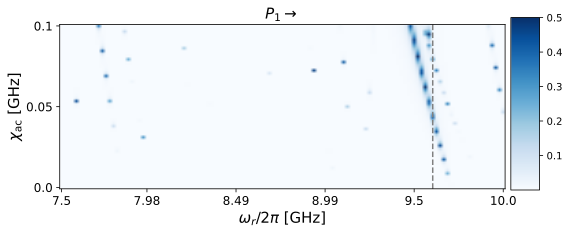

In [5]:
tmon_idx = 1  # Plot leakage probability for |e>. Try 0 for |g>
omega_d_idx = 100  # Drive frequency where we take a linecut

# Clipping the transition probability data at 0.5 gives nice-looking results.
# try plotting "bare_state_overlaps" or "intermediate_state_overlaps" instead of
# "displaced_state_overlaps" to look at the overlaps with the bare state or the
# displaced state obtained from fitting the intermediate amplitude regions,
# respectively. In the bare_state_overlaps results you can clearly see the effects of
# the ac stark shift, causing deviation of the floquet mode from the bare state
# even in the absence of a resonance.
plot_data = np.clip(
    1 - new_data_dict["displaced_state_overlaps"][:, :, tmon_idx].T ** 2, 0.0, 0.5
)
fig, ax = plt.subplots(figsize=(8, 8))
xticks = omega_d_linspace / (2.0 * np.pi)
yticks = chi_ac_linspace / (2.0 * np.pi)
num_x_pts = len(xticks)
num_y_pts = len(yticks)
im = plt.imshow(
    plot_data, origin="lower", cmap="Blues", aspect=0.75, interpolation="none"
)
plt.axvline(omega_d_idx, color="grey", ls="--")
ax.set_title(f"$P_{tmon_idx}$" + r"$\rightarrow$", fontsize=15)
xticklabel_locations = np.linspace(0, num_x_pts - 1, 6, dtype=int)
ax.set_xticks(xticklabel_locations)
ax.set_xticklabels(
    np.array(np.around(xticks[xticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
yticklabel_locations = np.linspace(0, num_y_pts - 1, 3, dtype=int)
ax.set_yticks(yticklabel_locations)
ax.set_yticklabels(
    np.array(np.around(yticks[yticklabel_locations], decimals=2), dtype=str),
    fontsize=12,
)
ax.set_ylabel(r"$\chi_{\rm ac}$ [GHz]", fontsize=15)
ax.set_xlabel(r"$\omega_r/2\pi$ [GHz]", fontsize=15)
cax = plt.axes([0.91, 0.35, 0.05, 0.3])
cbar = plt.colorbar(im, cax=cax)
plt.show()

## Branch analysis

We can compare these results with those obtained from the Blais branch analysis, giving us insight into which states are responsible for these transitions

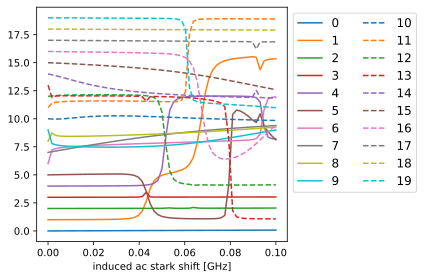

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_linspace / 2 / np.pi,
        new_data_dict["avg_excitation"][omega_d_idx, :, curve_idx],
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Quasienergies

We see that the scar plots and Blais plots both predict two locations (in drive power) where the first excited state can ionize. Lets look at the quasienergies to confirm that the quasienergies have an avoided crossing for the states experiencing branch crossings

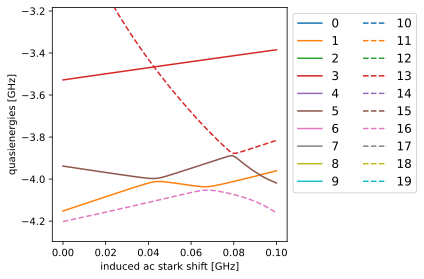

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
for curve_idx, sty in zip(
    range(floquet_analysis.hilbert_dim), color_ls_alpha_cycler, strict=False
):
    plt.plot(
        chi_ac_linspace / 2 / np.pi,
        new_data_dict["quasienergies"][omega_d_idx, :, curve_idx] / 2 / np.pi,
        label=curve_idx,
        **sty,
    )
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel("quasienergies [GHz]")
ax.legend(fontsize=12, ncol=2, loc="upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(-27 / 2 / np.pi, -20 / 2 / np.pi)
plt.tight_layout()
plt.show()

## Exploring the fit

The fit coefficients are returned by the analsysis, and if the Floquet modes have been saved we can plot the fitted state against the true Floquet modes.

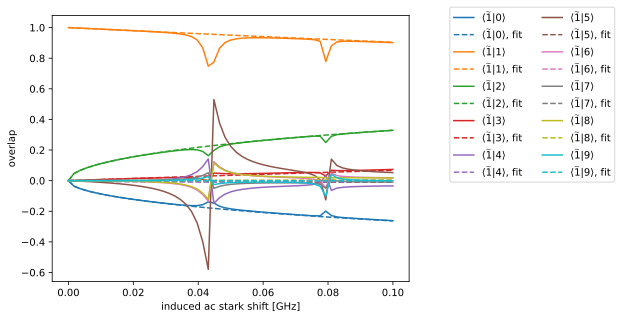

In [8]:
omega_d = omega_d_linspace[omega_d_idx]
displaced_state = ft.DisplacedState(
    hilbert_dim=floquet_analysis.hilbert_dim,
    model=model,
    state_indices=state_indices,
    options=options,
)


def state_for_amp(amp: float) -> qt.Qobj:
    return displaced_state.displaced_state(
        omega_d, amp, tmon_idx, new_data_dict["fit_data"][tmon_idx]
    )


fig, ax = plt.subplots()
for comp_idx, color in zip(range(10), color_cycler, strict=False):
    ideal_state_component = [
        np.real(
            qt.basis(floquet_analysis.hilbert_dim, comp_idx).dag() * state_for_amp(amp)
        )
        for amp in amp_linspace[:, omega_d_idx]
    ]
    # Components of the true Floquet mode
    plt.plot(
        chi_ac_linspace / 2 / np.pi,
        np.real(new_data_dict["floquet_modes"][omega_d_idx, :, tmon_idx, comp_idx]),
        label=rf"$\langle\widetilde{tmon_idx}|{comp_idx} \rangle$",
        color=color["color"],
    )
    # Components of the fitted state
    plt.plot(
        chi_ac_linspace / 2 / np.pi,
        np.real(np.squeeze(ideal_state_component)),
        ls="--",
        label=rf"$\langle\widetilde{tmon_idx}|{comp_idx} \rangle$, fit",
        color=color["color"],
    )
ax.legend(ncol=2, bbox_to_anchor=(1.1, 1.05))
ax.set_xlabel("induced ac stark shift [GHz]")
ax.set_ylabel("overlap")
plt.show()

We see that the fit goes straight through the resonances, as desired!